In [1]:
import pandas as pd
import pathlib, os, math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_repo_dir = pathlib.Path(os.getcwd()).parents[1]

In [3]:
'''
Confirm through assert statements that
A<-0 vs. A<-1 interventions do not change rankings
'''

kt_cf_path = base_repo_dir/'out'/'kendalls_tau_distances'/'err_sd'/'counterfactuals'
kt_cf_files = [f for f in sorted(os.listdir(kt_cf_path)) if f[0]!=['.']]

# Read in each counterfactual KT file
for file in kt_cf_files:
    
    df = pd.read_pickle(kt_cf_path /file, compression='gzip')
    
    # Assert all non-resolving counterfactual rankings identical for both interventions
    assert all(abs(1-df[df.nonres0_nonres1.isna()==False]['nonres0_nonres1'])<=1e-15),\
    'File {}:\nNon-resolving cf rankings differ between a<-0 and a<-1'.format(file)
    
    # Assert all X-resolving counterfactual rankings identical for both interventions
    assert all(abs(1-df[df.xres0_xres1.isna()==False]['nonres0_nonres1'])<=1e-15),\
    'File {}:\nX-resolving cf rankings differ between a<-0 and a<-1'.format(file)
    
    # Assert distance to non-resolving counterfactual ranking identical for both interventions
    assert all(df[(df.orig_nonres0.isna()==False)&(df.orig_nonres1.isna()==False)]['orig_nonres0']\
             ==df[(df.orig_nonres0.isna()==False)&(df.orig_nonres1.isna()==False)]['orig_nonres1']),\
    'File {}:\nDistance to non-resolving cf rankings differ between a<-0 and a<-1'.format(file)
    
    # Assert distance to X-resolving counterfactual ranking identical for both interventions
    assert all(df[(df.orig_xres0.isna()==False)&(df.orig_xres1.isna()==False)]['orig_xres0']\
             ==df[(df.orig_xres0.isna()==False)&(df.orig_xres1.isna()==False)]['orig_xres1']),\
    'File {}:\nDistance to X-resolving cf rankings differ between a<-0 and a<-1'.format(file)
    
    # Assert that wherever race was all 1, cf ranking unchanged by intervention
    assert all(abs(1-df[df.orig_nonres0.isna()]['orig_nonres1'])<=1e-15),\
    'File {}:\nCF Ranking changed by intervention by race was all 1'.format(file)
    
    # Assert that wherever race was all 0, cf ranking unchanged by intervention
    assert all(abs(1-df[df.orig_nonres1.isna()]['orig_nonres0'])<=1e-15),\
    'File {}:\nCF Ranking changed by intervention by race was all 0'.format(file)

In [4]:
def plot_sd_hist(sd):
    
    base_repo_dir = pathlib.Path(os.getcwd()).parents[1]
    kt_cf_path = base_repo_dir/'out'/'kendalls_tau_distances'/'err_sd'/'counterfactuals'

    dag_errs = ['x', 'y', 'xy_ind', 'xy_conf']
    dag_err_color_dict = {'x': 'navy', 'y': 'darkred', 'xy_ind':'rebeccapurple', 'xy_conf': 'plum'}

    dag_err_label_dict = {'x':'X has noise parent', 
                          'y':'Y has noise parent', 
                          'xy_ind':'X and Y each\nhave independent\nnoise parents', 
                          'xy_conf': 'Unmeasured confounding:\nX and Y share a\nsingle noise parent\n'}

    col_label_list = ['Expected[KT(original data,\ndata with resampled noise)]', 
                      'KT(original data,\ncounterfactual data with non-resolving X)', 
                      'KT(original data,\ncounterfactual data with resolving X)']

    dag_err_lines = [Line2D([0], [0], color=x, lw=6) \
             for x in dag_err_color_dict.values()]

    fig, ax = plt.subplots(4, 3, figsize=(14,10), dpi=100, sharex=True, sharey=True)

    plt.rcParams['hatch.color'] = 'lightgrey'
    for i, dag_err in enumerate(dag_errs):
        filename='{}_{}.pkl'.format(dag_err, sd)
        df = pd.read_pickle(kt_cf_path /filename, compression='gzip')

        ax[i][0].hist(df['exp_orig_noise'],density=True,
                   edgecolor = dag_err_color_dict[dag_err], 
                   label=dag_err_label_dict[dag_err], fill=False)

        ax[i][1].hist(df['orig_nonres0'], density=True,
                   color = dag_err_color_dict[dag_err], 
                   label=dag_err_label_dict[dag_err])

        ax[i][2].hist(df['orig_xres0'], density=True,
                   color = dag_err_color_dict[dag_err], 
                   label=dag_err_label_dict[dag_err], hatch='...')

        ax[i][1].legend(loc='center left', bbox_to_anchor=(-2,0.5), frameon=False)

    for j in range(len(col_label_list)):
        ax[0][j].set_title(col_label_list[j])
    plt.show()

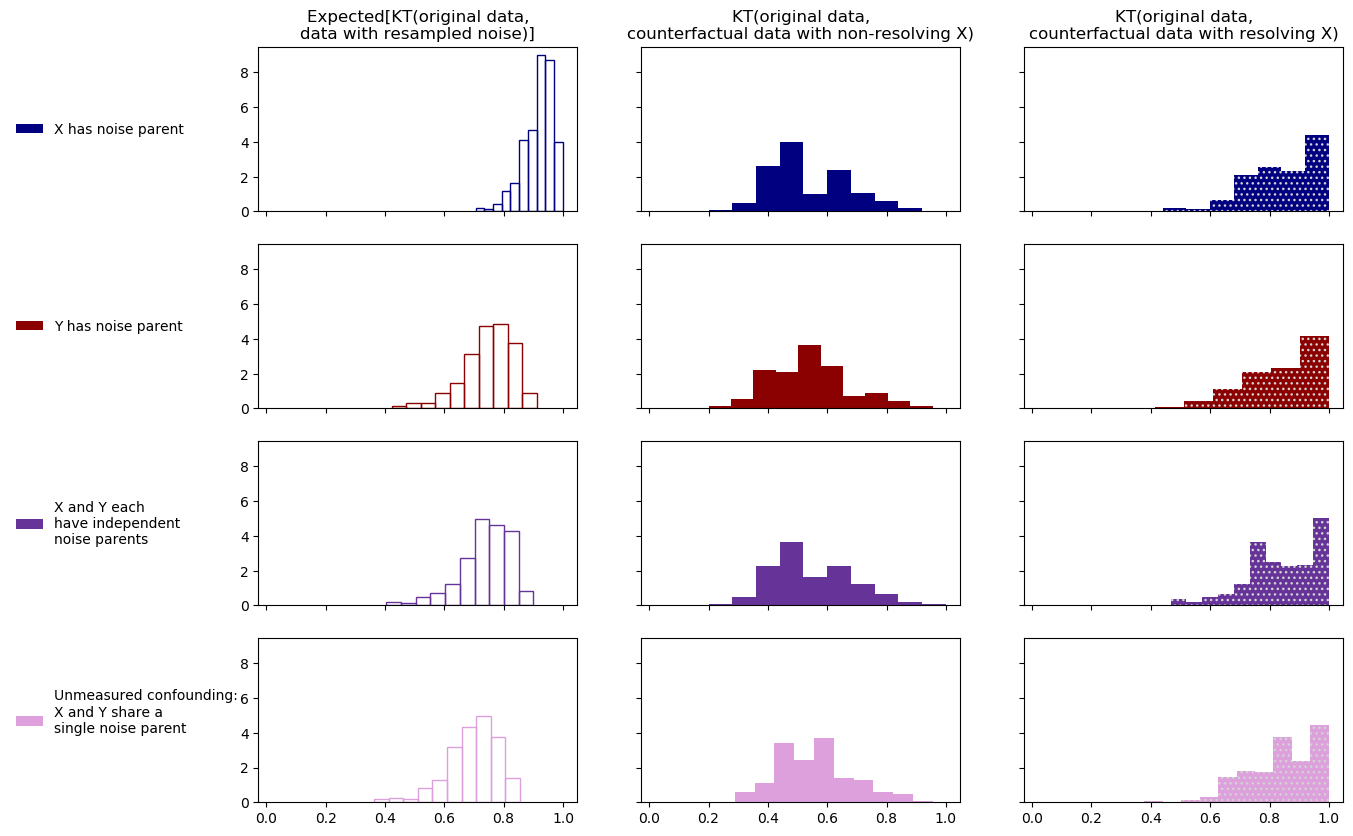

In [5]:
plot_sd_hist(0.1)

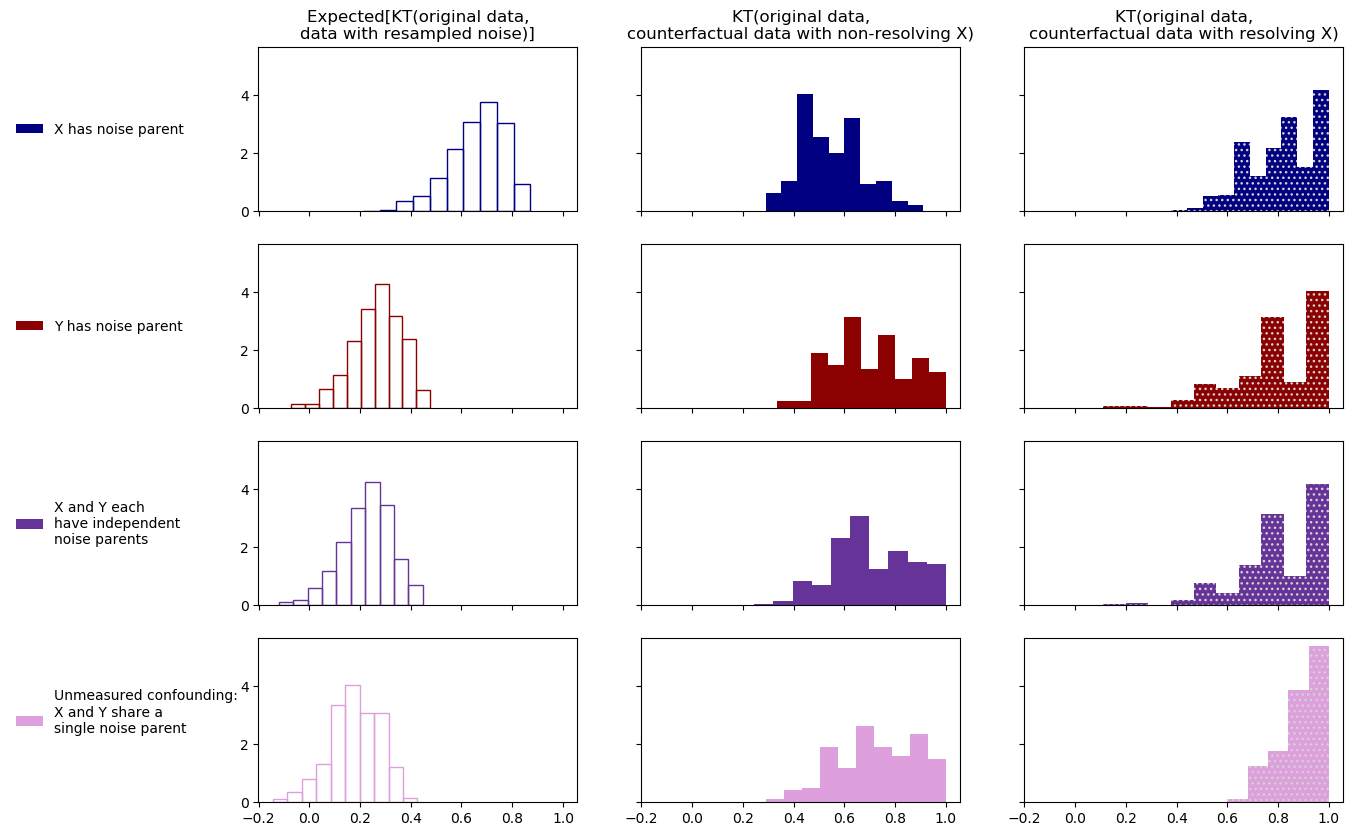

In [6]:
plot_sd_hist(0.5)

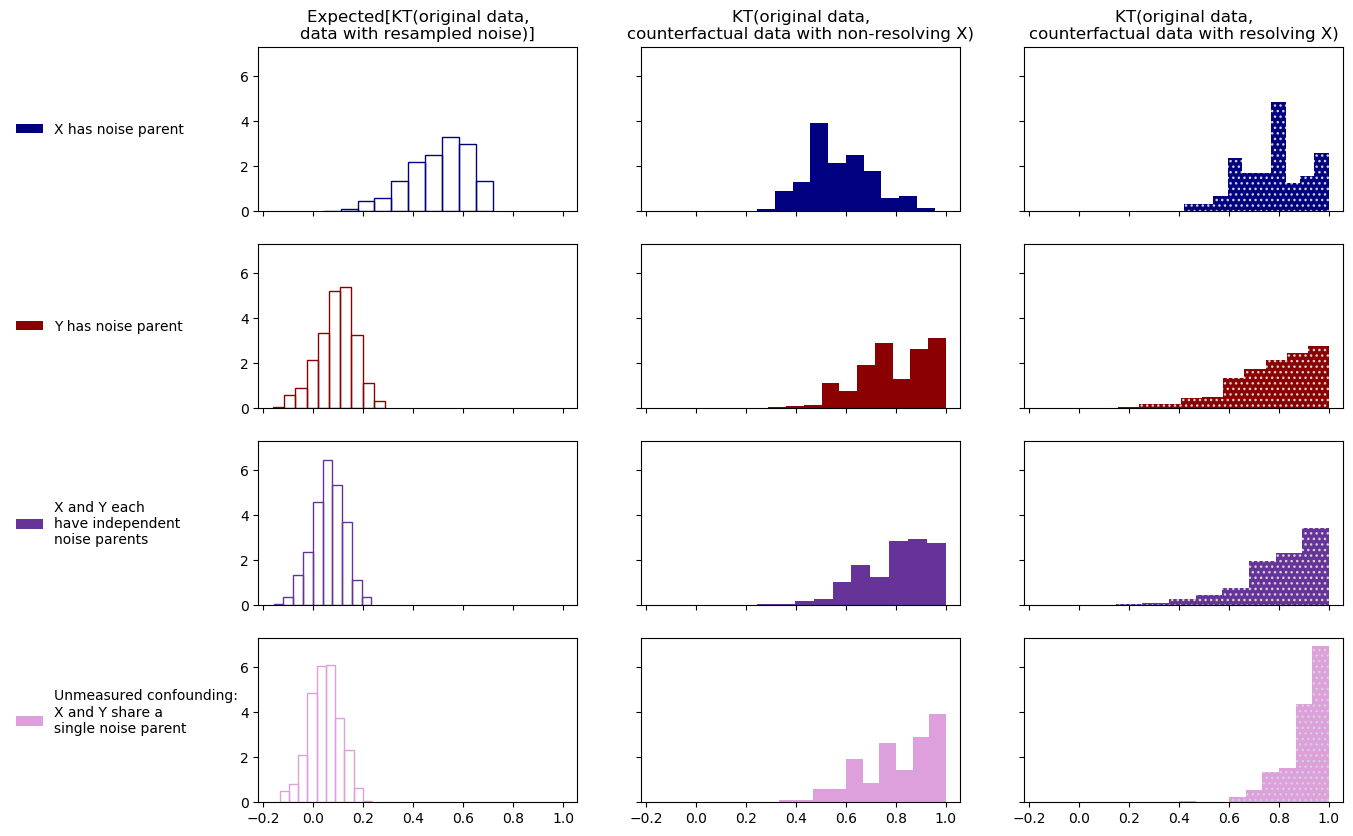

In [7]:
plot_sd_hist(1.0)

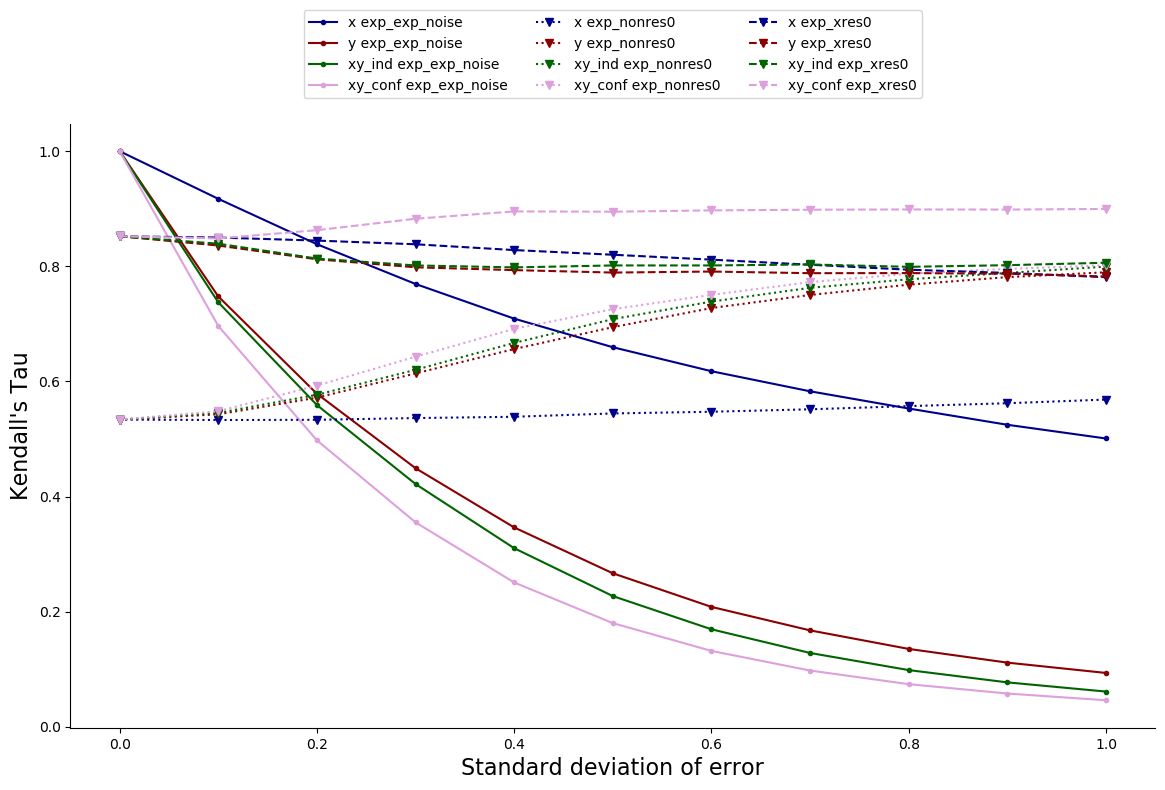

In [8]:
exp = pd.read_pickle(base_repo_dir/'out'/'kendalls_tau_distances'/'err_sd'/'expected.pkl',
                     compression='gzip')

dag_errs = ['x', 'y', 'xy_ind', 'xy_conf']
dag_err_color_dict = {'x': 'darkblue', 'y': 'darkred', 'xy_ind':'darkgreen', 'xy_conf': 'plum'}

sd_values = sorted(list(set([float(x[1]) for x in exp.index.values])))



col_linestyle_dict = {'exp_exp_noise':'solid', 
                      'exp_nonres0':'dotted', 'exp_nonres1':'dotted',
                      'exp_xres0':'dashed', 'exp_xres1':'dashed'}
col_marker_dict = {'exp_exp_noise':'.', 
                      'exp_nonres0':'v', 'exp_nonres1':'^',
                      'exp_xres0':'v', 'exp_xres1':'^'}

fig, ax = plt.subplots(1, 1, figsize=(14,8), dpi=100)

# make spines invisible
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for col in exp.columns:
    if "1" in col:
        continue
    for dag_err in dag_errs:
        ax.plot(sd_values, exp.loc[dag_err][col], 
                 color=dag_err_color_dict[dag_err],
                 linestyle=col_linestyle_dict[col],
                 marker = col_marker_dict[col],
                label=dag_err+' '+col)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.2))
ax.set_xlabel('Standard deviation of error', size=16)
ax.set_ylabel('Kendall\'s Tau', size=16)
plt.show()